In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [18]:
features = pd.read_csv("temps.csv")
features.head(5)

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


In [19]:
print(features.shape)

(348, 9)


In [20]:
import datetime

years = features["year"]
months = features["month"]
days = features["day"]

dates = [str(int(year)) + "_" + str(int(month)) + "_" + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, "%Y_%m_%d") for date in dates]


In [7]:
dates[:5]

[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 1, 2, 0, 0),
 datetime.datetime(2016, 1, 3, 0, 0),
 datetime.datetime(2016, 1, 4, 0, 0),
 datetime.datetime(2016, 1, 5, 0, 0)]

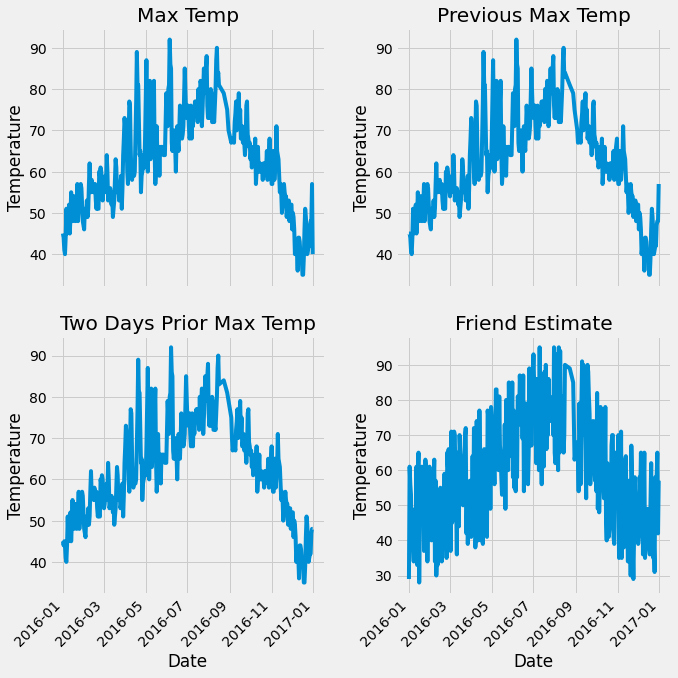

In [21]:
plt.style.use("fivethirtyeight")

# 设置布局
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
fig.autofmt_xdate(rotation = 45)

# 标签值
ax1.plot(dates, features['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature'); ax1.set_title('Max Temp')

# 昨天
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature'); ax2.set_title('Previous Max Temp')

# 前天
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature'); ax3.set_title('Two Days Prior Max Temp')

# 我的逗逼朋友
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature'); ax4.set_title('Friend Estimate')

plt.tight_layout(pad=2)

In [22]:
features = pd.get_dummies(features)
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,41,0,0,0,0,0,1,0


In [23]:
features.shape

(348, 15)

In [24]:
labels = np.array(features["actual"])
features = features.drop("actual", axis = 1)
feature_list = list(features.columns)
features = np.array(features)


In [26]:
from sklearn import preprocessing

In [27]:
input_features = preprocessing.StandardScaler().fit_transform(features)

In [28]:
input_features[0]

array([ 0.        , -1.5678393 , -1.65682171, -1.48452388, -1.49443549,
       -1.3470703 , -1.98891668,  2.44131112, -0.40482045, -0.40961596,
       -0.40482045, -0.40482045, -0.41913682, -0.40482045])

In [29]:
x = torch.tensor(input_features, dtype = float)
y = torch.tensor(labels, dtype=float)


In [38]:
input_size = input_features.shape[1]
hidden_size = 128
output_size = 1
batch_size = 16
epochs = 1000
device = torch.device("cuda:0")

my_nn = torch.nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.Sigmoid(),
    nn.Linear(hidden_size, output_size)
).to(device)

loss_f = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(my_nn.parameters(), lr = 1e-3)



In [44]:
losses = []
for i in range(epochs):
    batch_loss = []
    for start in range(0, len(input_features), batch_size):
        end = start + batch_size if start + batch_size < len(input_features) else len(input_features)
        xx = torch.tensor(input_features[start:end], dtype=torch.float, requires_grad=True).to(device)
        yy = torch.tensor(labels[start:end], dtype = torch.float, requires_grad=True).to(device)
        prediction = my_nn(xx)
        loss = loss_f(prediction, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())

    # batch_loss = torch.tensor(batch_loss)
    if i % 100 == 0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(losses))

0 32.90579544414174
100 32.828260530125014
200 32.74968546087092
300 32.67137509042567
400 32.594219641252
500 32.51854185624557
600 32.44435347519912
700 32.37169095602903
800 32.30062887885354
900 32.23112589229237


In [46]:
x = torch.tensor(input_features, dtype=torch.float).to(device)
predict = my_nn(x)

In [47]:
print(predict)

tensor([[47.5766],
        [47.8172],
        [47.4648],
        [48.4235],
        [47.9944],
        [48.1076],
        [47.9955],
        [47.9789],
        [48.2818],
        [48.7336],
        [49.7995],
        [48.0875],
        [48.5731],
        [48.0377],
        [48.0706],
        [48.5962],
        [51.3008],
        [51.3980],
        [51.4568],
        [50.4780],
        [50.9332],
        [49.8558],
        [51.2318],
        [51.9062],
        [53.2014],
        [51.2598],
        [53.3537],
        [51.8477],
        [53.8307],
        [52.9676],
        [52.2828],
        [50.7429],
        [52.7756],
        [52.1233],
        [52.8654],
        [52.7190],
        [52.7057],
        [53.0003],
        [52.6274],
        [53.9123],
        [53.9495],
        [55.0916],
        [53.0061],
        [52.7346],
        [54.2700],
        [53.2956],
        [53.7768],
        [54.5371],
        [55.0165],
        [55.2747],
        [54.6436],
        [56.3530],
        [55.